## Appending the csv files to create the Dataset 

### Glossário

<ul>
<li>Player : Player's first and last name</li>
<li>Pos : Position {PG : Point Guard, SG : Shooting Guard, SF : Small Forward, PF : Power Forward, C : Center}</li>
<li>Age : Player's age on February 1 of the season</li>
<li>G : Games Played</li>
<li>MP : Minutes Played</li>
<li>FG : Field Goals</li>
<li>FGA : Field Goal Attempts</li>
<li>FG% : Field Goal Percentage</li>
<li>3P : 3-Point Field Goals</li>
<li>3PA : 3-Point Field Goal Attempts</li>
<li>3P% : 3-Point Field Goal Percentage</li>
<li>2P : 2-Point Field Goals</li>
<li>2PA : 2-point Field Goal Attempts</li>
<li>2P% : 2-Point Field Goal Percentage</li>
<li>eFG% : Effective Field Goal Percentage</li>
<li>FT : Free Throws</li>
<li>FTA : Free Throw Attempts</li>
<li>FT% : Free Throw Percentage</li>
<li>ORB : Offensive Rebounds</li>
<li>DRB : Defensive Rebounds</li>
<li>TRB : Total Rebounds</li>
<li>AST : Assists</li>
<li>STL : Steals</li>
<li>BLK : Blocks</li>
<li>TOV : Turnovers</li>
<li>PF : Personal Fouls</li>
<li>PTS : Points</li>
<li>Status : Stamp to control the elected MVP and the other 4 more voted. OOR means 'Out of race'.</li>
<li>Season : Season's end year (e.g. Season 1979-1980 = 1980)</li>
</ul>


In [1]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

nba_dataset = pd.DataFrame()

for season in np.arange(1980,2021,1):
    df = pd.read_csv(f'./data/{season}std.csv', low_memory=False)    
    nba_dataset = nba_dataset.append(df)

display(nba_dataset)

,Player,Pos,Age,G,MP,FG,FGA,FG%,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Status,Season
0,Kareem Abdul-Jabbar,C,32,82,3143,835,1383,0.604,0,1,...,696,886,371,81,280,297,216,2034,MVP,1980
1,Tom Abernethy,PF,25,67,1222,153,318,0.481,0,1,...,129,191,87,35,12,39,118,362,OOR,1980
2,Alvan Adams,C,25,75,2168,465,875,0.531,0,2,...,451,609,322,108,55,218,237,1118,OOR,1980
3,Tiny Archibald,PG,31,80,2864,383,794,0.482,4,18,...,138,197,671,106,10,242,218,1131,Candidate,1980
4,Dennis Awtrey,C,31,26,560,27,60,0.450,0,0,...,86,115,40,12,15,27,66,86,OOR,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,Trae Young,PG,21,60,2120,546,1249,0.437,205,568,...,223,255,560,65,8,289,104,1778,OOR,2020
525,Cody Zeller,C,27,58,1341,251,479,0.524,18,75,...,251,411,88,40,25,75,140,642,OOR,2020
526,Tyler Zeller,C,30,2,4,1,4,0.250,0,0,...,1,4,0,0,0,0,0,2,OOR,2020
527,Ante Žižić,C,23,22,221,41,72,0.569,0,0,...,48,66,6,7,5,10,27,96,OOR,2020


I decided not to drop the Position and Age columns, just because a few players have the exact same first and last name, which implicates on duplicates in column Player.

## Feature Analysis<br>

<AxesSubplot:>

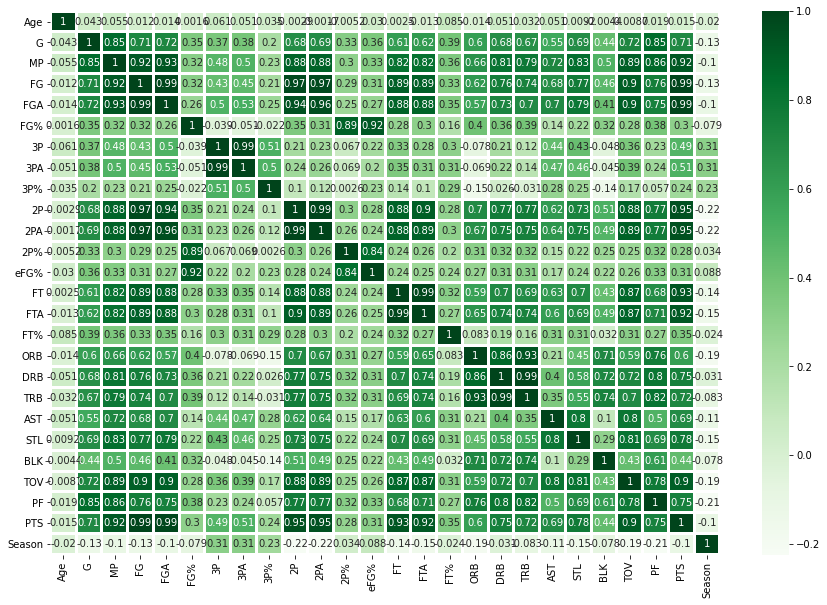

In [2]:
plt.figure(figsize=(15, 10))
sns.heatmap(nba_dataset.corr(), annot=True, cmap='Greens', linewidths=2)

As expected some features are strongly correlated, e.g. <b>FG = 2P+ 3P</b> or <b>PTS = 2*(2P) + 3*(3P)</b> or <b>3P% = 3P/3PA</b>.

Others like, **Games Played** or **Minutes Played** will be reflected on all major statistics.

So we don't need to keep all of them.

<AxesSubplot:>

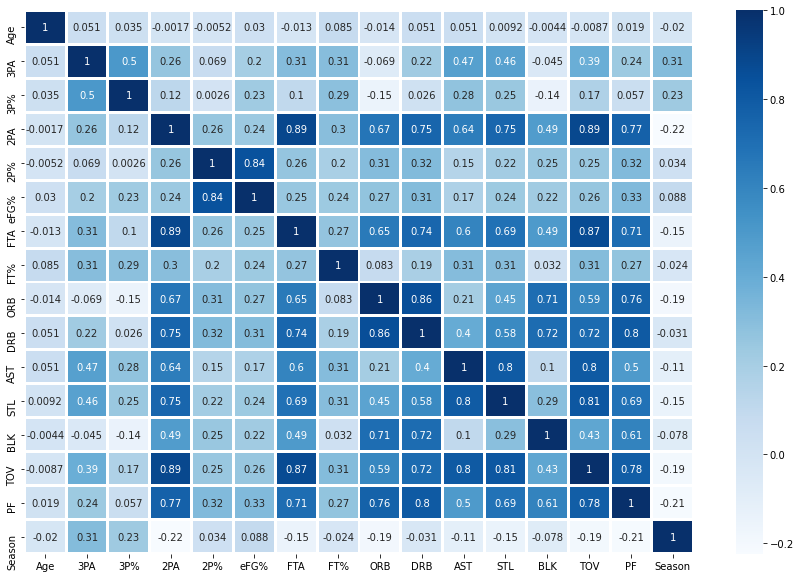

In [3]:
nba_dataset = nba_dataset.drop(columns=['G','MP','FG','FGA','FG%','3P','2P','FT','TRB','PTS'])
plt.figure(figsize=(15, 10))
sns.heatmap(nba_dataset.corr(), annot=True, cmap='Blues', linewidths=2)

## Functions Definition

In [4]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
#     df2 = df.loc[(df[nome_coluna] < lim_inf) | (df[nome_coluna] > lim_sup), :]
#     display(df2)
    df = df.loc[((df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup)) | (df['Status'] != 'OOR'), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

In [5]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.histplot(coluna)

def grafico_barra(coluna):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### 3-Point Field Goal Percentage

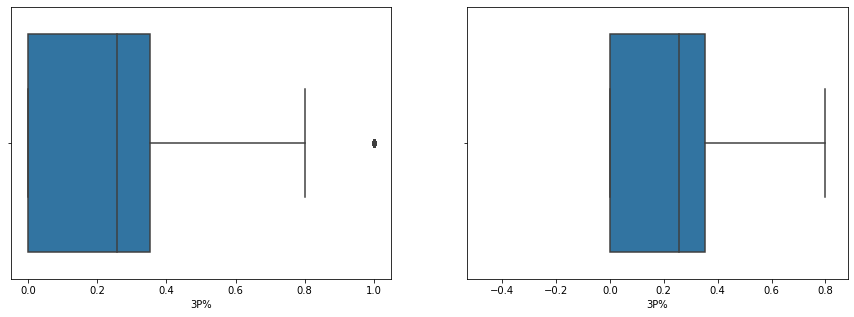

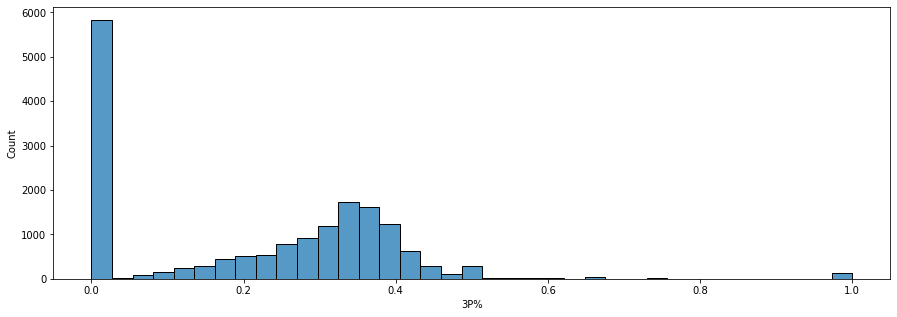

In [6]:
diagrama_caixa(nba_dataset['3P%'])
histograma(nba_dataset['3P%'])

Probably a fews guys had 1 3-pt attempt and managed to score. Those sharpshooters with 100% accuracy gonna be ignored.

In [7]:
nba_dataset, linhas_removidas = excluir_outliers(nba_dataset, '3P%')
print('{} linhas removidas'.format(linhas_removidas))

136 linhas removidas


(17003, 19)


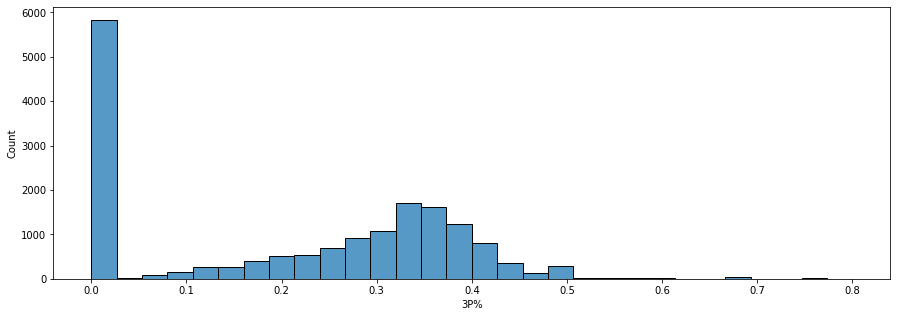

In [8]:
histograma(nba_dataset['3P%'])
print(nba_dataset.shape)